In [10]:
%%file fixtures.py
import pytest

BASE_URL_PETSTORE = 'http://localhost:5296/v2'


@pytest.fixture()
def api_store_order_endpoint():
    return f'{BASE_URL_PETSTORE}/store/order'


@pytest.fixture()
def api_user_endpoint():
    return f'{BASE_URL_PETSTORE}/user'


Overwriting fixtures.py


In [11]:
%%file models.py
from pydantic import BaseModel, Field
from typing import Optional
from datetime import datetime
from enum import Enum

class User(BaseModel):
    id: int
    username: str
    firstName: str
    lastName: str
    email: str
    password: str
    phone: str
    userStatus: int = Field(..., description="User Status")

class OrderStatus(str, Enum):
    PLACED = "placed"
    APPROVED = "approved"
    DELIVERED = "delivered"
    AVAILABLE = "available"

class Order(BaseModel):
    id: Optional[int] = None
    petId: Optional[int] = None
    quantity: Optional[int] = None
    shipDate: Optional[datetime] = None
    status: Optional[OrderStatus] = Field(None, description="Order Status")
    complete: Optional[bool] = False




Overwriting models.py


In [12]:
%%file test_api_user.py
import allure
import pytest
import requests
from fixtures import api_user_endpoint
from models import User

@allure.parent_suite('API')
@allure.suite('User')
@allure.sub_suite('Functional')
@allure.tag('User', 'Functional')
@allure.feature('User API')
@allure.story('Functional')
@allure.title('Test full user lifecycle: create, get, update, delete')
@pytest.mark.xfail(reason="API is known to be unstable")
@pytest.mark.parametrize('user,modified_user', [
    (User(id=657911, username="u9873460111", firstName="asdf", lastName="string",
          email="string", password="string", phone="string", userStatus=0),
     User(id=657911, username="u9873460111", firstName="fghh", lastName="fd",
          email="s84", password="s12", phone="s000", userStatus=2)),
])
def test_user_api_functional(api_user_endpoint, user: User, modified_user: User):
    username = user.username

    req_post = requests.post(api_user_endpoint, json=user.model_dump())
    assert req_post.status_code == 200

    req_get = requests.get(f'{api_user_endpoint}/{username}')
    assert req_get.status_code == 200
    retrieved_user = User.model_validate(req_get.json())
    assert retrieved_user == user

    req_put = requests.put(f'{api_user_endpoint}/{username}', json=modified_user.model_dump())
    assert req_put.status_code == 200

    req_get_modified = requests.get(f'{api_user_endpoint}/{username}')
    assert req_get_modified.status_code == 200
    retrieved_modified_user = User.model_validate(req_get_modified.json())
    assert retrieved_modified_user == modified_user

    req_del = requests.delete(f'{api_user_endpoint}/{username}')
    assert req_del.status_code == 200

    req_get_deleted = requests.get(f'{api_user_endpoint}/{username}')
    assert req_get_deleted.status_code == 404

@allure.parent_suite('API')
@allure.suite('User')
@allure.sub_suite('Negative')
@allure.tag('User', 'Negative', 'Get')
@allure.feature('User API')
@allure.story('Get Operations')
@allure.title('Test getting a non-existent user returns 404')
@pytest.mark.parametrize('username', ['nnasf123', '84230834', '---'])
def test_user_api_get_404(api_user_endpoint, username: str):
    req_get = requests.get(f'{api_user_endpoint}/{username}')
    assert req_get.status_code == 404

@allure.parent_suite('API')
@allure.suite('User')
@allure.sub_suite('Negative')
@allure.tag('User', 'Negative', 'Put')
@allure.feature('User API')
@allure.story('Put Operations')
@allure.title('Test updating a non-existent user returns 404')
@pytest.mark.parametrize('username', ['nonexistentuser1', 'nouserhere'])
def test_user_api_put_404(api_user_endpoint, username):
    user_data = User(id=12345, username=username, firstName="test", lastName="user",
                     email="test@example.com", password="password123", phone="1234567890", userStatus=1)
    req_put = requests.put(f"{api_user_endpoint}/{username}", json=user_data.model_dump())
    assert req_put.status_code == 200

@allure.parent_suite('API')
@allure.suite('User')
@allure.sub_suite('Negative')
@allure.tag('User', 'Negative', 'Delete')
@allure.feature('User API')
@allure.story('Delete Operations')
@allure.title('Test deleting a non-existent user returns 404')
@pytest.mark.parametrize('username', ['712471727412', '451472487129472918'])
def test_user_api_delete_404(api_user_endpoint, username):
    req_del = requests.delete(f"{api_user_endpoint}/{username}")
    assert req_del.status_code == 404





Overwriting test_api_user.py


In [13]:
!python -m pytest test_api_user.py

============================= test session starts =============================
platform win32 -- Python 3.13.1, pytest-9.0.2, pluggy-1.6.0
rootdir: C:\Users\fohtinok\PycharmProjects\PythonProject\7
plugins: allure-pytest-2.15.3, anyio-4.12.1
collected 8 items

test_api_user.py X.......                                                [100%]

======================== 7 passed, 1 xpassed in 0.19s =========================


In [14]:
%%file test_api_store.py
import pytest
import requests
import allure
from fixtures import api_store_order_endpoint
from models import Order
from datetime import datetime

@allure.parent_suite('API')
@allure.suite('Store')
@allure.sub_suite('Functional')
@allure.tag('Store', 'Functional')
@allure.feature('Store API')
@allure.story('Functional')
@allure.title('Test full order lifecycle: create, get, delete')
@pytest.mark.xfail(reason="API is known to be unstable")
@pytest.mark.parametrize('order', [
    Order(id=1239999, petId=1234, quantity=0, shipDate=datetime.fromisoformat("2026-02-06T19:23:11.238Z"),
          status="placed", complete=True),
    Order(id=123590999, petId=1234999, quantity=123, shipDate=datetime.fromisoformat("2025-02-06T20:23:21.238Z"),
          status="available", complete=True),
])
def test_store_api_functional(api_store_order_endpoint, order: Order):
    orderid = order.id

    req_post = requests.post(api_store_order_endpoint, json=order.model_dump(by_alias=True))
    assert req_post.status_code == 200

    req_get = requests.get(f'{api_store_order_endpoint}/{orderid}')
    assert req_get.status_code == 200

    retrieved_order = Order.model_validate(req_get.json())

    assert retrieved_order.id == order.id
    assert retrieved_order.petId == order.petId
    assert retrieved_order.quantity == order.quantity
    assert retrieved_order.status == order.status
    assert retrieved_order.complete == order.complete

    req_del = requests.delete(f'{api_store_order_endpoint}/{orderid}')
    assert req_del.status_code == 200

    req_get_deleted = requests.get(f'{api_store_order_endpoint}/{orderid}')
    assert req_get_deleted.status_code == 404

@allure.parent_suite('API')
@allure.suite('Store')
@allure.sub_suite('Negative')
@allure.tag('Store', 'Negative', 'Get')
@allure.feature('Store API')
@allure.story('Get Operations')
@allure.title('Test getting a non-existent order returns 404')
@pytest.mark.parametrize('orderid', ['99999', '101001', '84838'])
def test_store_api_get_404(api_store_order_endpoint, orderid):
    req_get = requests.get(f'{api_store_order_endpoint}/{orderid}')
    assert req_get.status_code == 404

@allure.parent_suite('API')
@allure.suite('Store')
@allure.sub_suite('Negative')
@allure.tag('Store', 'Negative', 'Delete')
@allure.feature('Store API')
@allure.story('Delete Operations')
@allure.title('Test deleting a non-existent order returns 404')
@pytest.mark.parametrize('orderid', ['987654321', '1122334455'])
def test_store_api_delete_404(api_store_order_endpoint, orderid):
    req_del = requests.delete(f"{api_store_order_endpoint}/{orderid}")
    assert req_del.status_code == 404








Overwriting test_api_store.py


In [15]:
!python -m pytest test_api_store.py

============================= test session starts =============================
platform win32 -- Python 3.13.1, pytest-9.0.2, pluggy-1.6.0
rootdir: C:\Users\fohtinok\PycharmProjects\PythonProject\7
plugins: allure-pytest-2.15.3, anyio-4.12.1
collected 7 items

test_api_store.py xx.....                                                [100%]

======================== 5 passed, 2 xfailed in 0.28s =========================


In [16]:
%%file test_api_store_extended.py
import pytest
import requests
import allure
from datetime import datetime
from fixtures import api_store_order_endpoint
from models import Order, OrderStatus

@allure.parent_suite('API')
@allure.suite('Store')
@allure.sub_suite('Post and Get')
@allure.tag('Store', 'Post', 'Get')
@allure.feature('Store API')
@allure.story('Post Operations')
@allure.title('Test creating and retrieving various valid orders')
@pytest.mark.xfail(reason="API is known to be unstable with frequent timeouts or 500 errors")
@pytest.mark.parametrize('order', [
    Order(id=778899, petId=10, quantity=1, shipDate=datetime(2026, 2, 5, 20, 30), status=OrderStatus.APPROVED, complete=True),
    Order(id=445566, petId=20, quantity=5, shipDate=datetime(2026, 2, 6, 20, 50), status=OrderStatus.DELIVERED, complete=False),
])
def test_create_and_get_valid_orders(api_store_order_endpoint, order):
    order_id = order.id

    post_response = requests.post(
        api_store_order_endpoint,
        data=order.model_dump_json(),
        headers={'Content-Type': 'application/json'}
    )
    assert post_response.status_code == 200
    posted_order = Order.model_validate(post_response.json())
    assert posted_order.id == order.id
    assert posted_order.status == order.status

    get_response = requests.get(f'{api_store_order_endpoint}/{order_id}')
    assert get_response.status_code == 200
    retrieved_order = Order.model_validate(get_response.json())

    assert retrieved_order.id == order.id
    assert retrieved_order.petId == order.petId
    assert retrieved_order.quantity == order.quantity
    assert retrieved_order.status == order.status
    assert retrieved_order.complete == order.complete

    delete_response = requests.delete(f'{api_store_order_endpoint}/{order_id}')
    assert delete_response.status_code == 200

@allure.parent_suite('API')
@allure.suite('Store')
@allure.sub_suite('Post Negative')
@allure.tag('Store', 'Negative', 'Post')
@allure.feature('Store API')
@allure.story('Post Operations')
@allure.title('Test creating an order with invalid data types')
@pytest.mark.parametrize('invalid_field, invalid_value', [
    ('id', 'id-int'),
    ('petId', '-int'),
    ('quantity', '-int')
])
def test_create_order_with_invalid_data(api_store_order_endpoint, invalid_field, invalid_value):
    base_order = Order(
        id=999111, petId=123, quantity=1,
        shipDate=datetime(2025, 10, 31, 23, 59),
        status=OrderStatus.PLACED, complete=True
    )
    order_json = base_order.model_dump()
    order_json['shipDate'] = order_json['shipDate'].isoformat() + "Z"
    order_json[invalid_field] = invalid_value

    post_response = requests.post(api_store_order_endpoint, json=order_json)
    assert post_response.status_code == 500

@allure.parent_suite('API')
@allure.suite('Store')
@allure.sub_suite('Delete')
@allure.tag('Store', 'Negative', 'Delete')
@allure.feature('Store API')
@allure.story('Delete Operations')
@allure.title('Test that deleting an order makes it irretrievable')
@pytest.mark.xfail(reason="API is known to be unstable")
def test_delete_order_and_verify_not_found(api_store_order_endpoint):
    order_data = Order(
        id=333222, petId=987, quantity=10,
        shipDate=datetime(2026, 1, 1, 0, 0),
        status=OrderStatus.PLACED, complete=False
    )
    order_id = order_data.id

    post_response = requests.post(
        api_store_order_endpoint,
        data=order_data.model_dump_json(),
        headers={'Content-Type': 'application/json'}
    )
    assert post_response.status_code == 200

    delete_response = requests.delete(f'{api_store_order_endpoint}/{order_id}')
    assert delete_response.status_code == 200

    get_response = requests.get(f'{api_store_order_endpoint}/{order_id}')
    assert get_response.status_code == 404


Overwriting test_api_store_extended.py


In [17]:
!python -m pytest test_api_store_extended.py

============================= test session starts =============================
platform win32 -- Python 3.13.1, pytest-9.0.2, pluggy-1.6.0
rootdir: C:\Users\fohtinok\PycharmProjects\PythonProject\7
plugins: allure-pytest-2.15.3, anyio-4.12.1
collected 6 items

test_api_store_extended.py XX...X                                        [100%]

======================== 3 passed, 3 xpassed in 0.20s =========================


In [18]:
!python -m pytest test_api_store.py test_api_user.py test_api_store_extended.py --alluredir allure-results

============================= test session starts =============================
platform win32 -- Python 3.13.1, pytest-9.0.2, pluggy-1.6.0
rootdir: C:\Users\fohtinok\PycharmProjects\PythonProject\7
plugins: allure-pytest-2.15.3, anyio-4.12.1
collected 21 items

test_api_store.py xx.....                                                [ 33%]
test_api_user.py X.......                                                [ 71%]
test_api_store_extended.py XX...X                                        [100%]

================== 15 passed, 2 xfailed, 4 xpassed in 0.37s ===================


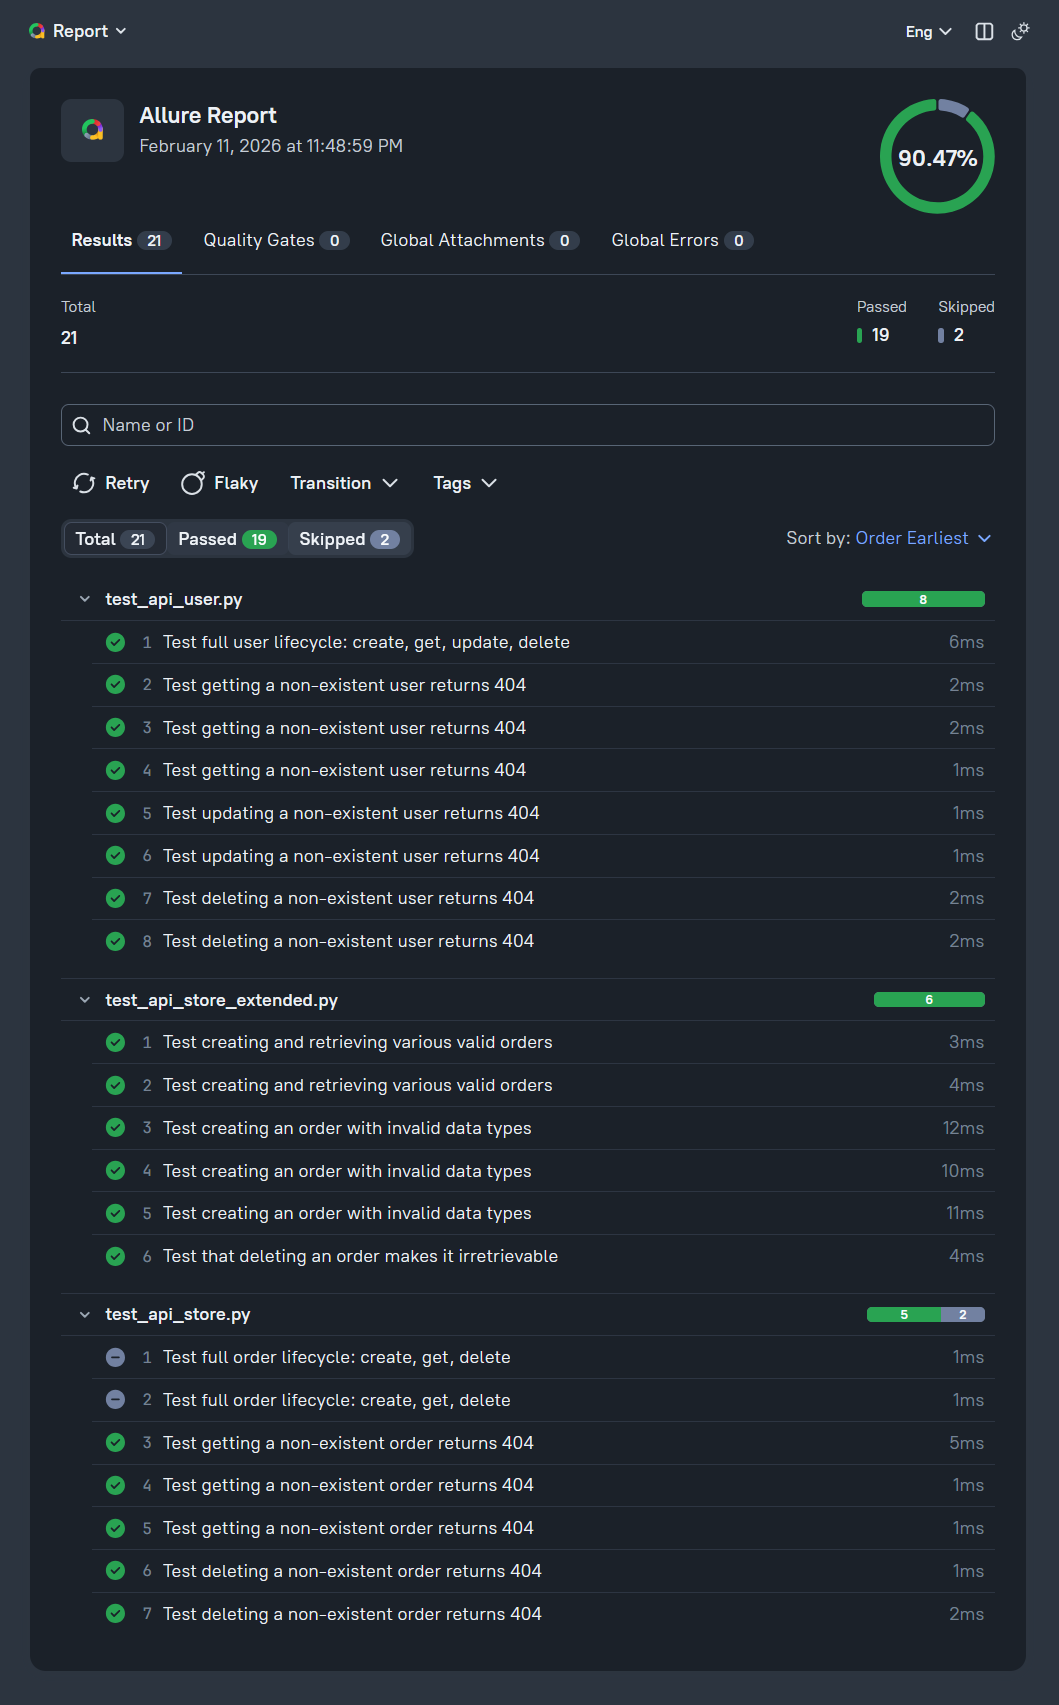